First text:
Can you help me with my project?
This is the current situation:
1. I work in python, file .ipynb
2. So far I completed the following points:
2.1. Data cleaning
2.2 I-Tree Eco Analysis
2.3 Data Modeling
Now I want to create a Data Analysis section. Let's start from the data, attached you can find a sample of data from the data modeling section (geojson format). What I want to do here is, firstly, we aim to gain a nuanced understanding of our dataset, exploring internal correlations and uncovering the underlying patterns that define the urban tree ecosystem in Bologna. Secondly, our endeavor extends to the identification of the most fitting regression model that not only elucidates the current state of the data but also serves as a robust foundation for predictive modeling, facilitating informed decisions in future urban forestry planning. After this we will create a predictive model (the output will be a species of tree and a position (lat, long) where we think is the best place to put a new tree) with the trained model we will then calculate the 'Total Annual Benefits (eur/yr)', the dependent variable, so that we can evaluate how much the municipality can save for the new suggested trees. The independent variables may be the input of the ITree Eco tool, that gave us the 'Total Annual Benefits (eur/yr)' value in first place, in particular those are: 'DBH (cm)', 'Name_id', 'Latitude', 'Longitude', 'Height (m)'.
Now I want you to guide me, step by step, to create this analysis. Please take in consideration the following points:
- we want to structure it as a scientific analysis so we have to deeply argue all our choices and add all the descriptions of methods and models that we use
- we have to evaluate different models
Let's start with the first step, this is how I will load the data:
"trees = gpd.read_file('../data/geojson/geo_data_trees.geojson')"
What do I have to do next? Please always motivate your choices.

In [2]:
import geopandas as gpd
#import pysal
import libpysal as lp
from spreg import OLS
import numpy as np

# WE ARE WORKING WITH A SAMPLE OF THE DATA
# Load your tree dataset with coordinates and ecological benefits
trees = gpd.read_file('../data/geojson/geo_data_trees.geojson')
# take a random sample of the dataset (5000 rows)
#trees = trees.sample(n=5000)

trees = trees.drop([len(trees)-1])

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 84939 entries, 0 to 84938
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Tree ID                              84939 non-null  object  
 1   Name                                 84939 non-null  object  
 2   DBH (cm)                             84939 non-null  object  
 3   Replacement Value (eur)              84939 non-null  object  
 4   Carbon Storage (kg)                  84939 non-null  object  
 5   Carbon Storage (eur)                 84939 non-null  object  
 6   Gross Carbon Sequestration (kg/yr)   84939 non-null  object  
 7   Gross Carbon Sequestration (eur/yr)  84939 non-null  object  
 8   Avoided Runoff (l/yr)                84939 non-null  object  
 9   Avoided Runoff (eur/yr)              84939 non-null  object  
 10  Carbon Avoided (kg/yr)               84939 non-null  object  
 11  Carbon 

<AxesSubplot:>

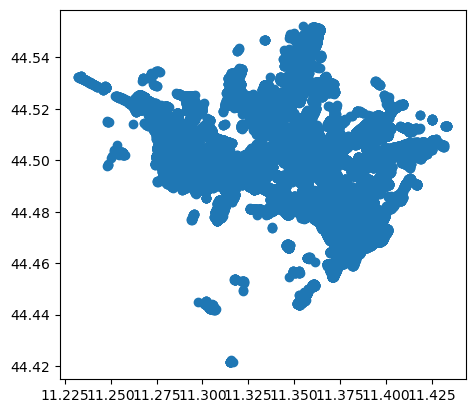

In [3]:
# Explore the data structure
print(trees.info())

# Display the first few rows
print(trees.head())

# Generate descriptive statistics
print(trees.describe())

# Check for null values
print(trees.isnull().sum())

# Visualize the geospatial distribution (requires additional setup for plotting)
trees.plot()


<AxesSubplot:>

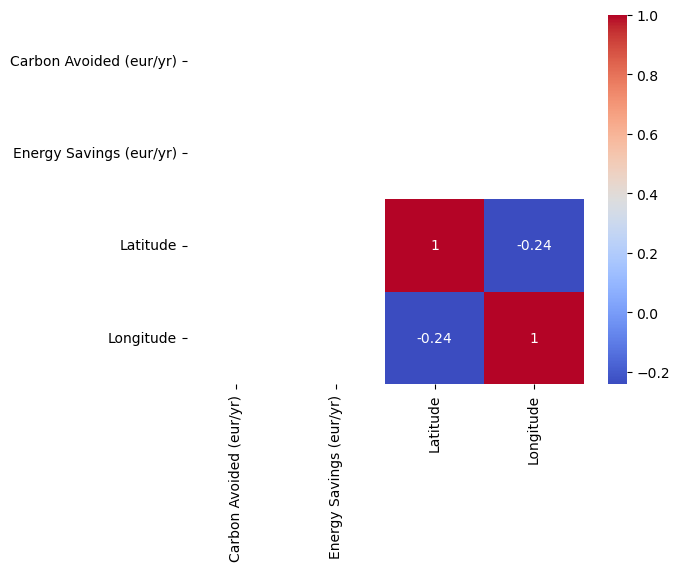

In [4]:
# Correlation Analysis
import seaborn as sns
sns.heatmap(trees.corr(), annot=True, cmap='coolwarm')

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Convert object columns to numeric where appropriate
trees["Total Annual Benefits (eur/yr)"] = trees["Total Annual Benefits (eur/yr)"].astype(float)
trees['DBH (cm)'] = trees['DBH (cm)'].astype(float)
trees["Height (m)"] = trees["Height (m)"].astype(float)
trees['Name_id'] = trees['Name'].astype('category').cat.codes

# Splitting the dataset
X = trees[['DBH (cm)', 'Name_id', 'Latitude', 'Longitude', 'Height (m)']]
y = trees['Total Annual Benefits (eur/yr)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Example: Evaluating Linear Regression
lr_model = LinearRegression()
lr_scores = cross_val_score(lr_model, X_train, y_train, cv=5)
print(f"Linear Regression Scores: {lr_scores}")


Linear Regression Scores: [0.70303851 0.69185313 0.69866128 0.69903542 0.69061756]


In [8]:
import pysal as ps
import spreg
import numpy as np
from pysal.lib import weights

# Prepare your data
X = trees[['DBH (cm)', 'Name_id', 'Latitude', 'Longitude', 'Height (m)']].values
y = trees['Total Annual Benefits (eur/yr)'].values.reshape((-1,1))

w_knn = weights.KNN.from_dataframe(trees, k=8)
w_knn.transform = 'R'

# Create a Spatial Lag Model
sar_model = spreg.ML_Lag(y, X, w=w_knn, name_y='Total Annual Benefits (eur/yr)', name_x=['DBH (cm)', 'Name_id', 'Latitude', 'Longitude', 'Height (m)'])

# Output the results
print(sar_model.summary)

/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 277 disconnected components.
  warnings.warn(message)
/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


: 

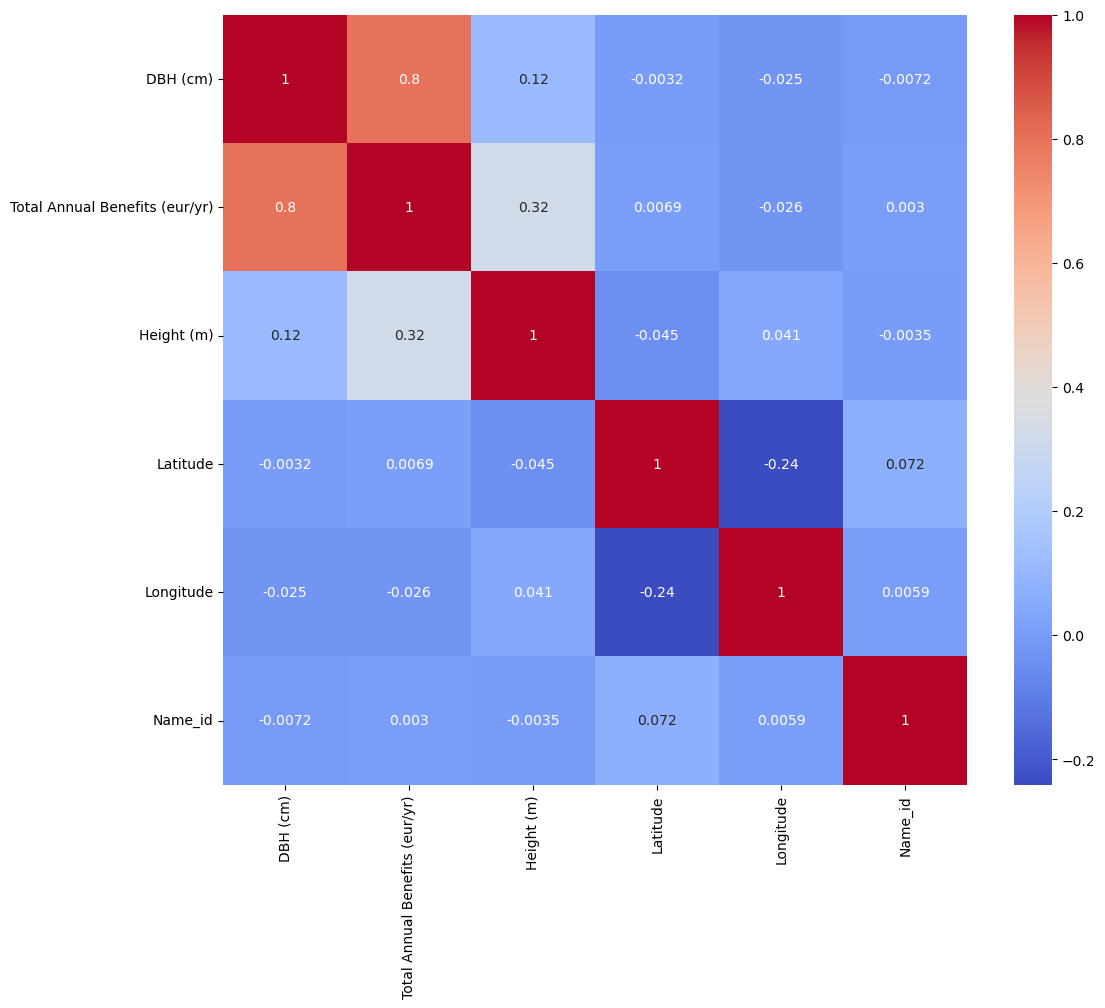

In [ ]:
import pandas as pd

# Convert object columns to numeric where appropriate
trees["Total Annual Benefits (eur/yr)"] = trees["Total Annual Benefits (eur/yr)"].astype(float)
trees['DBH (cm)'] = trees['DBH (cm)'].astype(float)
trees["Height (m)"] = trees["Height (m)"].astype(float)
trees['Name_id'] = trees['Name'].astype('category').cat.codes

# Handle missing values
trees.drop(['Carbon Avoided (eur/yr)', 'Energy Savings (eur/yr)', 'Species Name'], axis=1, inplace=True)

# Correlation Analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = trees.corr()

# Generate a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold

# Assuming 'trees' is your DataFrame and 'Total Annual Benefits (eur/yr)' is the target variable
X = trees[['DBH (cm)', 'Name_id', 'Latitude', 'Longitude', 'Height (m)']]
y = trees['Total Annual Benefits (eur/yr)']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Establish a baseline model, such as a simple linear regression
from sklearn.linear_model import LinearRegression
baseline_model = LinearRegression()

# Perform cross-validation
cv = KFold(n_splits=10, random_state=42, shuffle=True)
cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

# Calculate the mean and standard deviation of the cross-validated scores
cv_scores_mean = cv_scores.mean()
cv_scores_std = cv_scores.std()

print(f"CV Mean Score: {cv_scores_mean}, CV Standard Deviation: {cv_scores_std}")

CV Mean Score: -3.2616594135810986, CV Standard Deviation: 0.07981499051449434


### Summary model tables
\begin{table}[ht]
    \centering
    \begin{tabular}{lcc}
        \toprule
        \textbf{Variable} & \textbf{Coefficient} & \textbf{p-value} \\
        \midrule
        CONSTANT & -45.138 & 0.000 \\
        DBH (cm) & 0.033 & 0.000 \\
        Name\_id & -0.00004 & 0.137 \\
        Latitude & 0.985 & 0.000 \\
        Longitude & 0.020 & 0.652 \\
        Height (m) & 0.076 & 0.000 \\
        \bottomrule
    \end{tabular}
    \caption{OLS Model Results}
    \label{tab:ols_results}
\end{table}

% Include extended OLS results table here
\begin{table}[ht]
    \centering
    \begin{tabular}{lcc}
        \toprule
        \textbf{Variable} & \textbf{Coefficient} & \textbf{p-value} \\
        \midrule
        CONSTANT & -111.250 & 0.000 \\
        DBH (cm) & 0.094 & 0.000 \\
        Name\_id & 0.00041 & 0.000 \\
        Latitude & 2.729 & 0.000 \\
        Longitude & -0.987 & 0.000 \\
        Height\_m & 0.134 & 0.000 \\
        Spatial Lag of Height (w\_height) & -0.00061 & 0.013 \\
        \bottomrule
    \end{tabular}
    \caption{Extended OLS Model Results}
    \label{tab:extended_ols_results}
\end{table}

% Include GWR results table here
\begin{table}[ht]
    \centering
    \begin{tabular}{lcc}
        \toprule
        \textbf{Variable} & \textbf{Coefficient} & \textbf{p-value} \\
        \midrule
        DBH & 0.0949289 & 0.0000000 \\
        Name\_id & 0.0004209 & 0.0000094 \\
        Latitude & 2.7884996 & 0.0000000 \\
        Longitude & -1.0485292 & 0.0000000 \\
        Height (m) & 0.1337181 & 0.0000000 \\
        \bottomrule
    \end{tabular}
    \caption{GWR Model Results}
    \label{tab:gwr_results}
\end{table}